In [3]:
# ===============================================================
#  Merge per‑file stress arrays into a single flat dictionary
# ---------------------------------------------------------------
from pathlib import Path
import meshio
import numpy as np
from typing import Dict

def vtu_folder_to_stress_dict(root_dir: str ,
                              verbose: bool = True) -> Dict[str, np.ndarray]:
    """
    Recursively search *root_dir* for .vtu files and assemble a flat
    dictionary {field_name : ndarray}.  Assumes each VTU stores **one**
    array in point_data or cell_data.

    Returns
    -------
    stress_dict : Dict[str, np.ndarray]
        Keys are full field names exactly as stored in the VTU
        (e.g., 'Stress:Normal XX').  Values are 1‑D NumPy arrays.

    Notes
    -----
    • Geometry consistency is not checked here—add it if you rely on it.
    • Duplicate field names will be overwritten by the last file found.
    """
    root_dir = Path(root_dir)
    stress_dict: Dict[str, np.ndarray] = {}

    for vtu_path in sorted(root_dir.rglob("*.vtu")):
        mesh = meshio.read(vtu_path)

        # Search point_data then cell_data for the first non‑empty field
        field_name, field_data = None, None
        for k, arr in mesh.point_data.items():
            if arr.size:
                field_name, field_data = k, arr
                break
        if field_name is None:
            for block in mesh.cell_data:
                for k, arr in block.items():
                    if arr.size:
                        field_name, field_data = k, arr
                        break
            if field_name is None:
                if verbose:
                    print(f"[WARN] {vtu_path.name} contains no data, skipped")
                continue

        stress_dict[field_name] = field_data
        if verbose:
            print(f"✓ {vtu_path.name}  →  '{field_name}'  (size={field_data.size})")

    return stress_dict, mesh


In [10]:

# ===============================================================
#   Example usage
# ---------------------------------------------------------------

folder = "Data\Drone FEA"
stress, mesh = vtu_folder_to_stress_dict(folder)

print("\nFinal dict keys:", stress.keys())
print("Array shape of Sxx (if present):", stress.get("Stress:Normal XX", []).shape)


✓ XX.vtu  →  'Stress:Normal XX'  (size=61649)
✓ XY.vtu  →  'Stress:Shear XY'  (size=61649)
✓ YY.vtu  →  'Stress:Normal YY'  (size=61649)
✓ YZ.vtu  →  'Stress:Shear YZ'  (size=61649)
✓ ZX.vtu  →  'Stress:Shear ZX'  (size=61649)
✓ ZZ.vtu  →  'Stress:Normal ZZ'  (size=61649)

Final dict keys: dict_keys(['Stress:Normal XX', 'Stress:Shear XY', 'Stress:Normal YY', 'Stress:Shear YZ', 'Stress:Shear ZX', 'Stress:Normal ZZ'])
Array shape of Sxx (if present): (61649,)


In [5]:
# ===============================================================
#   Convert flat dict → 2‑D NumPy array  (N rows × 6 cols)
# ---------------------------------------------------------------
import numpy as np

ORDER = [
    "Stress:Normal XX",
    "Stress:Normal YY",
    "Stress:Normal ZZ",
    "Stress:Shear XY",
    "Stress:Shear YZ",
    "Stress:Shear ZX",
]


def stress_dict_to_matrix(stress_dict: dict,
                          order: list[str] = ORDER,
                          dtype=float) -> np.ndarray:
    """
    Return an (N, 6) array whose columns follow *order*.

    Raises
    ------
    KeyError   if any requested component is missing.
    ValueError if component arrays have different lengths.
    """
    # ── 1. check presence ──────────────────────────────────────────
    missing = [k for k in order if k not in stress_dict]
    if missing:
        raise KeyError(f"Missing components in stress_dict: {missing}")

    # ── 2. check equal length ──────────────────────────────────────
    lengths = [stress_dict[k].size for k in order]
    if len(set(lengths)) != 1:
        raise ValueError("Component arrays differ in length:" +
                         ", ".join(f"{k}={n}" for k, n in zip(order, lengths)))

    # ── 3. stack columns ───────────────────────────────────────────
    matrix = np.column_stack([stress_dict[k].astype(dtype, copy=False)
                              for k in order])
    return matrix

# -----------------------------------------------------------------
stress_matrix = stress_dict_to_matrix(stress)  # ← 'stress' from Step 3
print("Matrix shape:", stress_matrix.shape)    # (N, 6)


Matrix shape: (1416, 6)


In [6]:
# ===============================================================
#   Principal stresses & directions
# ---------------------------------------------------------------
import numpy as np

def principal_stress_and_dirs(stress_mat: np.ndarray):
    """
    Parameters
    ----------
    stress_mat : (N, 6) array
        Columns in order [Sxx, Syy, Szz, Sxy, Syz, Szx].

    Returns
    -------
    princ_vals : (N, 3) array
        Principal stresses λ₁ ≥ λ₂ ≥ λ₃ for every row.
    princ_vecs : (N, 3, 3) array
        Corresponding principal directions (unit vectors).  Each
        row i is a 3×3 matrix whose columns are v1, v2, v3.
    """
    N = stress_mat.shape[0]
    # --- 1. build symmetric tensors ---------------------------------
    T = np.zeros((N, 3, 3))
    T[:, 0, 0] = stress_mat[:, 0]          # Sxx
    T[:, 1, 1] = stress_mat[:, 1]          # Syy
    T[:, 2, 2] = stress_mat[:, 2]          # Szz
    T[:, 0, 1] = T[:, 1, 0] = stress_mat[:, 3]   # Sxy
    T[:, 1, 2] = T[:, 2, 1] = stress_mat[:, 4]   # Syz
    T[:, 2, 0] = T[:, 0, 2] = stress_mat[:, 5]   # Szx

    # --- 2. eigen‑decomposition (vectorised) ------------------------
    # eigh guarantees eigen‑values ascending ==> flip for descending
    evals, evecs = np.linalg.eigh(T)          # evals: (N,3), evecs: (N,3,3)
    princ_vals = np.flip(evals,  axis=-1)     # λ₁ ≥ λ₂ ≥ λ₃
    princ_vecs = np.flip(evecs,  axis=-1)     # same reorder for vectors

    return princ_vals, princ_vecs


# ------------------------------------------------------------------
principal_vals, principal_dirs = principal_stress_and_dirs(stress_matrix)

print("principal_vals shape:", principal_vals.shape)   # (N, 3)
print("principal_dirs shape:", principal_dirs.shape)   # (N, 3, 3)


principal_vals shape: (1416, 3)
principal_dirs shape: (1416, 3, 3)


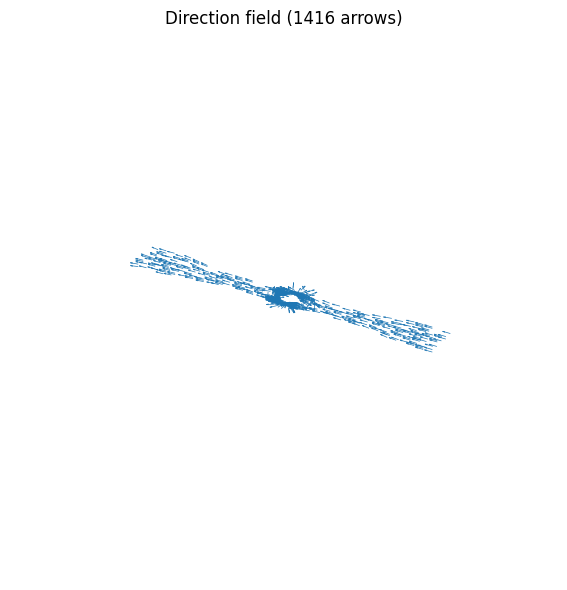

In [7]:
# ===============================================================
# Visualise vectors in 3-D
# ---------------------------------------------------------------

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_vectors(coords: np.ndarray,
                 vecs:   np.ndarray,
                 max_arrows: int = 20_000,
                 arrow_len: float = 1,
                 figsize=(8, 6)):
    """
    Shows quiver arrows (all unit-length × arrow_len) in 3-D.

    • max_arrows : draw at most this many arrows (random sample).
    • arrow_len  : scaling factor for arrow length in plot units.
    """
    # --- down-sample if too many ----------------------------------
    if coords.shape[0] > max_arrows:
        idx = np.random.choice(coords.shape[0], max_arrows, replace=False)
        coords = coords[idx]
        vecs   = vecs[idx]

    # --- normalise then scale for visual clarity ------------------
    norms = np.linalg.norm(vecs, axis=1, keepdims=True)
    norms[norms == 0] = 1                    # avoid divide-by-zero
    vecs_n = vecs / norms * arrow_len

    # --- plot -----------------------------------------------------
    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(111, projection="3d")
    ax.view_init(elev=30, azim=-60) 
    grid=range(0,coords.shape[0]-1, 2)
    ax.quiver(
        coords[grid, 0], coords[grid, 1], coords[grid, 2],
        vecs_n[grid, 0], vecs_n[grid, 1], vecs_n[grid, 2],
        length=30.0, normalize=False, linewidth=0.5
    )


    ax.set_title(f"Direction field ({coords.shape[0]} arrows)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    max_range = (coords.max(axis=0) - coords.min(axis=0)).max() / 2.0
    mid = coords.mean(axis=0)
    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

plot_vectors(mesh.points, principal_dirs[:, :, 0], max_arrows=25_000, arrow_len=0.15)

In [36]:
# ===============================================================
# 6️⃣  Weighted PCA on v3 directions  (weights = |λ₃|)
# ---------------------------------------------------------------
import numpy as np

def weighted_pca_vectors(vectors: np.ndarray,
                         weights:  np.ndarray):
    """
    Weighted PCA for a set of 3‑D vectors.

    Parameters
    ----------
    vectors : (N, 3) array
        Each row is a 3‑D direction vector (here v3).
    weights : (N,) array
        Non‑negative weights (here |λ₃|).

    Returns
    -------
    u1 : (3,)  dominant principal component (unit vector).
    eigvals : (3,)  eigen‑values λ₁ ≥ λ₂ ≥ λ₃ of the weighted covariance.
    eigvecs : (3, 3) columns = principal directions u1, u2, u3.
    """
    if np.any(weights < 0):
        raise ValueError("weights must be non‑negative")

    w_sum = weights.sum()
    if w_sum == 0:
        raise ValueError("all weights are zero")

    # ── weighted mean ─────────────────────────────────────────────
    mean = (weights[:, None] * vectors).sum(axis=0) / w_sum

    # ── weighted covariance (zero‑mean data) ─────────────────────
    Vc = vectors - mean
    C = (weights[:, None, None] *
         (Vc[:, :, None] * Vc[:, None, :])).sum(axis=0) / w_sum

    # ── eigen‑decomposition (symmetric) ───────────────────────────
    eigvals, eigvecs = np.linalg.eigh(C)          # ascending
    idx = eigvals.argsort()[::-1]                 # descending
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    u1 = eigvecs[:, 0]
    return u1, eigvals, eigvecs


# -----------------------------------------------------------------
# all first principle directions (column 0 after flip)  &  weights = max(0,λ1)
v1_vecs = principal_dirs[:, :, 0]          # (N, 3)

weights = np.clip(principal_vals[:, 0], a_min=0, a_max=None)    # non‑negative

u1, eigvals, eigvecs = weighted_pca_vectors(v1_vecs, weights)

print("Dominant PCA direction 1 (u1):", eigvecs[:,0])
print("Dominant PCA direction 2 (u2):", eigvecs[:,1])

print("Least PCA direction, the printing direction (u3):", eigvecs[:,2])

print("Explained‑variance ratio  λ3 / Σλ =", eigvals[2] / eigvals.sum())
print("R=1- λ3 / λ1 =", 1-eigvals[2] / eigvals[0])

Dominant PCA direction 1 (u1): [-1.91079307e-02 -9.99817387e-01  2.83128785e-04]
Dominant PCA direction 2 (u2): [-0.99973047  0.01910253 -0.01319371]
Least PCA direction, the printing direction (u3): [-1.31858965e-02  5.35157054e-04  9.99912919e-01]
Explained‑variance ratio  λ3 / Σλ = 0.0077128896733855866
R=1- λ3 / λ1 = 0.9899162392598119


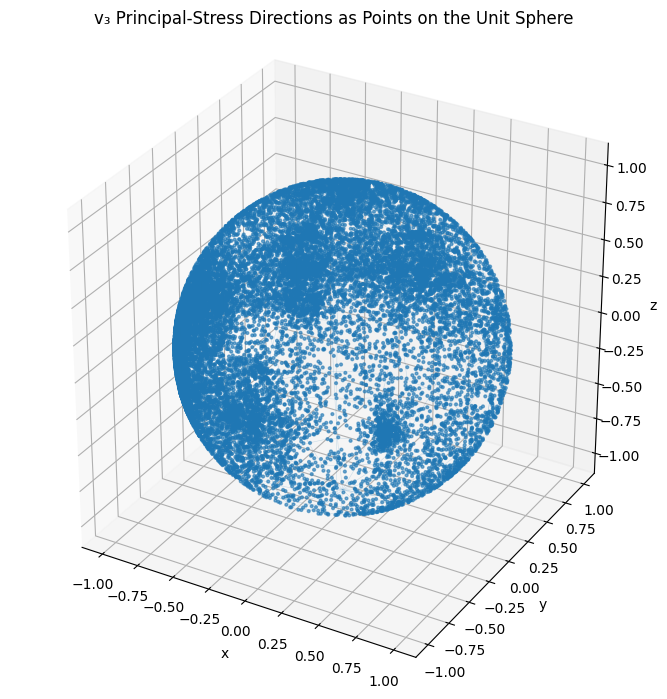

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ------------------------------------------------------------------
# Assumes principal_dirs (N,3,3) already exists.
# Column index 2 corresponds to v3 (direction of smallest principal stress)
# ------------------------------------------------------------------

v1 = principal_dirs[:, :, 0]                       # (N, 3)

# Normalise to unit length (just in case)
v1 = v1 / np.linalg.norm(v1, axis=1, keepdims=True)

# Optional down‑sample for readability
max_pts = 20_000
if v1.shape[0] > max_pts:
    idx = np.random.choice(v1.shape[0], max_pts, replace=False)
    v1 = v1[idx]

# ------------------------------------------------------------------
# Plot: each direction vector is shown as a point on the unit sphere
# ------------------------------------------------------------------
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(v1[:, 0], v1[:, 1], v1[:, 2], s=4, alpha=0.6)

# Draw a light unit‑sphere wireframe for reference
u = np.linspace(0, 2 * np.pi, 30)
v = np.linspace(0, np.pi, 15)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones_like(u), np.cos(v))
ax.plot_wireframe(x, y, z, rstride=2, cstride=2, linewidth=0.4, alpha=0.2)

ax.set_title("v₃ Principal‑Stress Directions as Points on the Unit Sphere")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_box_aspect([1, 1, 1])    # equal aspect ratio
ax.Projection='ortho'
plt.tight_layout()
plt.show()


In [79]:
# output all the first princinpal directions
import numpy as np
import pandas as pd
from pathlib import Path

# ------------------------------------------------------------------
# v1 : (N, 3) array of unit‑length vectors  ← make sure it exists
# ------------------------------------------------------------------
# Example: v3 = principal_dirs[:, :, 0] after your eigen‑decomposition

# Optional: give every node an index column
node_ids = np.arange(len(v1))

# Build a DataFrame for clarity / optional headers
df = pd.DataFrame(
    np.column_stack([principal_dirs[:, :, 0], principal_vals[:, 0]]),
    columns=["vx", "vy", "vz","w"]
)

# Choose a destination
out_csv = Path("v1_directions.csv")

# Save
df.to_csv(out_csv, index=False, float_format="%.8e")  # scientific notation

print(f"Saved {len(df)} vectors to {out_csv.resolve()}")


Saved 6709 vectors to F:\phd\maoLab\sysmeter1\msec2026\code\v1_directions.csv
